# L3b: Market Inference of Future Interest Rates
In this lecture we will continue our exploration of yield curves and the term-structure of interest rates. We will introduce a very interesting Treasury security called a STRIPS (Separate Trading of Registered Interest and Principal of Securities) bond.

> __Motivation__: We looked at the __par yield curve__ in the previous lecture. However, we were left with the question of how to compute the discount factors for all maturities in the par yield curve. Today, we'll show that these values can be observed in the market by looking at the price of a special zero coupon bond called a STRIP bond. This will allow us to compute the spot rate (discount rate at a point in time) curve for different maturities, from which we can compute the par yield curve.

By the end of this lecture, you should be able to:
* __STRIPS Bonds__: Separate Trading of Registered Interest and Principal of Securities (STRIPS) bonds are zero coupon bonds that are created by separating (stripping) the interest payments from the principal payment of a Treasury security. We will learn how to price STRIPS bonds and how they can be used to infer the spot rate curve from the par yield curve.
* __Spot Rate Curve__: We will learn how to compute the spot rate curve from the par yield curve using STRIPS bonds. This will involve understanding how to price STRIPS bonds and how to use their prices to infer the spot rates for different maturities.
* __Short Rate Curve__: Short rates are the projected interest rate between two periods in the future. We will learn how to compute the short rate curve from the spot rate curve and how it relates to the par yield curve.

Let's get started!
___

## Examples
We'll look at the following examples to illustrate the key concepts of the lecture:
* [▶ Pricing Registered Interest and Principal of Securities (STRIPS) Bonds](CHEME-5660-L3b-STRIPS-Issuer-Example-Fall-2025.ipynb). This example will familiarize students with the ideas behind pricing [Registered Interest and Principal of Securities (STRIPS)](https://www.treasurydirect.gov/marketable-securities/strips/) bonds from the perspective of the issuer.

___

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 

> __Include:__ The [include(...) function](https://docs.julialang.org/en/v1/base/base/#include) is a convenient way to load Julia code from another file. The `Include.jl` file is a Julia file that loads external packages, and various functions that we will use in the exercise. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Otherwise, packages are downloaded and then loaded.

Setup the environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # this sets up the environment, we'll do this all the time, on everything we do

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We have compiled a STRIPS bond data set from J.P. Morgan dated September 10, 2025. This data set contains the prices and yield to maturity of various STRIPS bonds with different maturities.

This file is a comma separated values (CSV) file named `US-Treasury-STRIPS-Prices-TD-09-10-25.csv` and is located in the `data` folder. We've written [the `MyTreasurySTRIPSDataSet()` helper function](../src/Files.jl#L14-L18) to load this data set into a DataFrame.

In [5]:
strips_dataset = MyTreasurySTRIPSDataSet()

Row,CUSIP,Maturity,Coupon,YTM_bid,YTM_ask,Price_bid,Price_ask
,String15,Date,Int64,Float64,Float64,Float64,Float64
1,912833LX6,2025-11-15,0,3.744,3.744,99.343,99.343
2,912833LY4,2026-02-15,0,3.823,3.574,98.395,98.498
3,9128202R7,2026-05-15,0,3.904,3.487,97.418,97.688
4,912833PA2,2026-08-15,0,3.703,3.48,96.657,96.854
5,912803BJ1,2026-11-15,0,3.404,3.244,96.106,96.284
6,912833PC8,2027-02-15,0,3.598,3.43,95.04,95.264
7,912833PD6,2027-05-15,0,3.61,3.491,94.178,94.363
8,912833PE4,2027-08-15,0,3.633,3.487,93.298,93.557
9,912833QB9,2027-11-15,0,3.601,3.455,92.526,92.815


___

## Concept Review
The __yield curve__ is a graphical representation of the relationship between interest rates (or yields) and the time to maturity of debt securities. It is an important tool in finance and economics, as it provides insights into market expectations for future interest rates, inflation, and economic growth.

The yield curve can take on different shapes, each of which can provide different insights into market expectations. The three most common shapes of the yield curve are:
* __Normal Yield Curve__: A normal yield curve is upward sloping, indicating that longer-term debt securities have higher yields than shorter-term securities. This is typically seen in a healthy economy, where investors expect future interest rates to rise.
* __Inverted Yield Curve__: An inverted yield curve is downward sloping, indicating that shorter-term debt securities have higher yields than longer-term securities. This is often seen as a sign of an impending recession, as investors expect future interest rates to fall.
* __Flat Yield Curve__: A flat yield curve indicates that there is little difference in yields between short-term and long-term debt securities. This can indicate uncertainty in the market, as investors are unsure about future interest rates and economic growth.

The yield curve is typically constructed by computing a hypothetical yield called the par yield for different maturities. The par yield is the yield at which a bond would trade at par value, meaning that the bond's price is equal to its face value. The par yield is given by:
$$
\boxed{\displaystyle \bar c_{\text{par}}(T) 
= n\cdot\frac{1 - \mathcal{D}^{-1}_{nT,0}(\bar r)}{\sum_{j=1}^{nT}\mathcal{D}^{-1}_{j,0}(\bar r)}.}
$$
where $n$ is the number of coupon payments per year, $T$ is the time to maturity in years, $\mathcal{D}^{-1}_{j,0}(\bar r)$ is the (inverse) discount factor for the $j^{th}$ coupon payment, and $\bar r$ is the __yield to maturity__ (YTM) of a zero coupon bond with maturity of $T$ years.

> __Today:__ Ok, so if $\bar{r} = \bar{Y}$, for different maturities, where do we get this number from? If this is the yield to maturity for a hypothetical zero coupon bond, how do we compute it, especially for longer duration instruments (T-bills have a maximum length of only one year). 

That's where STRIPS bonds come in. Let's check these bonds out.
___

<div>
    <center>
        <img src="figs/Fig-Schematic-STRIPS.svg" width="680"/>
    </center>
</div>

## What is a STRIPS Bond?
STRIPS, short for [Separate Trading of Registered Interest and Principal of Securities](https://treasurydirect.gov/marketable-securities/strips/) bonds, offer investors a unique fixed-income investment opportunity to access the income and coupon payments of Treasury securities. STRIPS are components of a coupon-bearing Treasury instrument, such as a Treasury note or bond, that have been separated (or "stripped") into individual zero-coupon securities.

> __How are STRIPS created?__ STRIPS are created by separating a Treasury security's coupon and principal components and trading them as zero-coupon securities. For a $T$ year Treasury note or bond, with $n$ coupon payments, there will be $nT+1$ STRIPS created: one for each coupon payment and one for the principal payment at maturity. A broker-dealer or financial institution will typically purchase a Treasury security, strip the coupons and principal, and then sell the individual STRIPS to investors.

Beyond their immediate value as investment tools, STRIPS are interesting as they provide another perspective on the [Term Structure of Interest Rates](https://www.investopedia.com/terms/t/termstructure.asp#:~:text=Essentially%2C%20term%20structure%20of%20interest,current%20state%20of%20an%20economy). They allow us to compute the spot rate curve, which we need to understand the par-yield curve.

<div>
    <center>
        <img src="figs/Fig-STRIPS-JPM-09-08-25.png" width="980"/>
    </center>
</div>

So STRIPS are zeros that can be traded separately. Can we capture the relationship between the yield to maturity, the time to maturity and price of a STRIPS bond?
___

## How are STRIPS Bonds Priced?
STRIPS are sold at a discount compared to their face value. However, it's important to note that the secondary seller, i.e., the brokerage splitting the original note or bond, determines that discount (at least initially). 

To better understand this, let's look at this question of STRIPS pricing from two perspectives: first, we are interested in buying a STRIPS bond from the secondary market (we are a consumer), and second, we are interested in pricing a STRIPS bond that we are creating from a Treasury security (we are a STRIPS issuer).

> __Example:__ Can we compute the price of a STRIPS Bond on the Secondary Market?
> When purchasing (as a consumer) a STRIPS bond from the secondary market, the price is determined by the discount rate applied to the face value of the bond. This discount rate is the > __yield to maturity (YTM)__ of the STRIPS bond, which reflects the market's current interest rates for similar securities.

Let's use our data snapshot shown above to see if we can replicate the yield to maturity for these STRIPS products, and then go back to compute the price of the STRIPS bond.

In [3]:
Ȳ,VB = let

    # initialize -
    how_many_days_till_maturity = ((Date(2031, 11, 15) - Date(2025, 9, 8)).value);
    TR = how_many_days_till_maturity / 365.0;
    VB = 79.363; # this is the price of the STRIPS bond in the secondary market, as of 09/08/2025

    # Setup a zero coupon model for the STRIPS bond -
    zero_coupon_model = build(MyUSTreasuryZeroCouponBondModel, (
        par = 100.0,
        n = 2,
        T = TR,
        rate = 0.0, # we don't know this yet, we are going to compute it
    ));

    # compute the yield to maturity for this STRIPS bond -
    (ytm, ytm_estimates) = yieldtomaturity(zero_coupon_model;
        TR = TR,
        price = VB,
        ϵ = 1e-10,
        maxiter = 1000,
    );

    ytm, VB; # return 
end

(0.037346321946398225, 79.363)

__Hmmmm:__ I found something interesting when I looked at the yield to maturity for the STRIPS bonds in the JPMorgan data. 

> __Fun fact:__ To replicate the JPMorgan data, a continuous compounding assumption was required to replicate the observed yield to maturity values shown in the data. This is a bit unexpected, as I would have thought that the yield to maturity would be computed using discrete compounding! Wow, that is cool.

I learn something new every year I teach this course! So how about the price?

> __Test:__ Can we compute the price of a STRIPS bond given the value of the yield to maturity $\bar{Y}$? Let's take the $\bar{Y}$ value from the JPMorgan data and see if we can compute the price of the STRIPS bond. We check if our price is similar to the JPMorgan data using [the `@assert` macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with [the `isapprox(...)` function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox). If the values don't match, [an `AssertionError` is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError).

So what do we see?

In [4]:
let

    # initialize -
    discount_model = ContinuousCompoundingModel(); # Super interesting, this is what was needed to replicate the JPMorgan data!
    how_many_days_till_maturity = ((Date(2031, 11, 15) - Date(2025, 9, 8)).value);
    TR = how_many_days_till_maturity / 365.0;

    # compute the price of a zero coupon bond using the yield to maturity we computed above -
    zero_coupon_model = build(MyUSTreasuryZeroCouponBondModel, (
        par = 100.0,
        n = 2,
        T = TR,
        rate = Ȳ, # use the yield to maturity we computed above
    )) |> discount_model;

    # do we blow up?
    @assert isapprox(zero_coupon_model.price, VB; atol=1e-4); # use the absolute tolerance, we could also use relative tolerance
end

### Let's look at STRIPS pricing from the perspective of a STRIPS issuer.
When we are creating STRIPS bonds from a Treasury security, we need to determine the price at which we will sell the individual STRIPS bonds. This price is determined by the yield to maturity (YTM) that we want to offer to investors for each STRIPS bond. 

Let's consider three ways to price the STRIPS bonds that we are creating from a Treasury security:

> __Scheme 1 constant yield__: In this approach, the brokerage prices the zero-coupon instruments to have a constant yield $\bar{r}$. This can be achieved by setting the price as an escalating fraction of the par value $V_{B} = \left(\alpha\right)^{T}\cdot{V}_{P}$, where $\alpha\leq{1}$, and $T$ represents the time to maturity of the generated zero coupon bond.

> __Scheme 2 constant discount__: The brokerage prices the zero-coupon instruments to have a constant discount, i.e., the ratio of price to face value is constant across all instruments. In this case, $V_{B} = \left(\alpha\right)\cdot{V}_{P}$ is not a function of the time to maturity of the instrument, and $\alpha\leq{1}$.

> __Scheme 3:__ In this scheme, we allow the yield to vary with the maturity of the bond. Suppose the yield we are willing to sell the bond for is given by:
> $$
\bar{r}_{i} = \theta_{1}+\theta_{2}\cdot\left(i-1\right)^{\beta}
> $$
> where $i$ denotes the STRIPS index, $\theta_{1}$ denotes the interest rate for the shortest term bond, $\theta_{2}$ governs how fast the rate escalates for each pass of the loop, i.e., for each bond of longer maturity that we sell, and $\beta$ is a sensitivity parameter. Because $\theta_{1}>{0}$, $\theta_{2}\geq{0}$, and $\beta>0$ this scheme will give a _normal_ yield curve $\bar{r}_{i}\leq\bar{r}_{i+1}$, i.e., longer-term maturity will have a higher yield compared to shorter-term bonds.

Let's implement each of these schemes and see how they compare.
> __Example__
>
> [▶ Pricing Registered Interest and Principal of Securities (STRIPS) Bonds](CHEME-5660-L3b-STRIPS-Issuer-Example-Fall-2025.ipynb). This example will familiarize students with the ideas behind pricing [Registered Interest and Principal of Securities (STRIPS)](https://www.treasurydirect.gov/marketable-securities/strips/) bonds from the perspective of the issuer.

___

## Calculate the Par Yield Curve from the Spot Rate Curve
Let's do a quick example to see how we can compute the par yield curve from the spot rate curve. The 3-month par yield for 4.1% on 09-08-25. While we are a few days off from the exact date, let's see if we can compute this value using our STRIPS data set.

In [19]:
cpar, ratio = let

    # get the YTM value for a 3-month STRIPS bond
    Ȳ = 0.03455; # Observation date 09-10-25, maturity date 11-15-27
    T = (Date(2027, 11, 15) - Date(2025, 9, 10)).value / 365.0;
    n = 2; # semi-annual compounding
    number_of_periods = (T * n) |> round |> Int;
    discount_model = DiscreteCompoundingModel(); # let's try discrete compounding
    discount_dictionary = discount(discount_model, Ȳ, number_of_periods);

    # compute the par yield -
    denominator = sum((discount_dictionary[i])^-1 for i ∈ 1:number_of_periods); # wow! that is fancy
    numerator = 1.0 - (discount_dictionary[number_of_periods])^-1;
    ratio = numerator / denominator;
    par_yield = ratio * n;

    par_yield, ratio; # return
end

(0.03454999999999979, 0.017274999999999895)

What's the spot rate curve (the yield to maturity for the STRIPS bonds) telling us now?

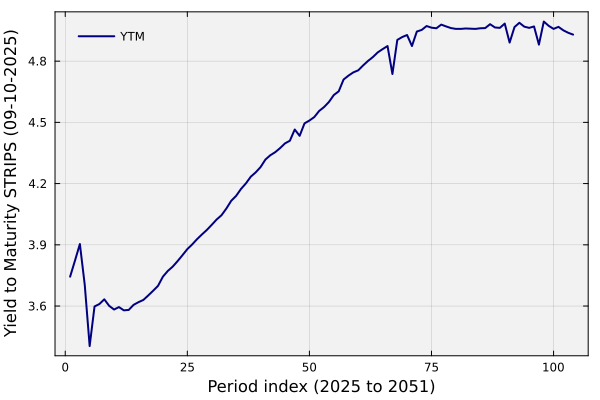

In [28]:
let

    # initialize -
    ytm_array = strips_dataset[:, "YTM_bid"];
    plot(ytm_array, lw=2, label="YTM", c=:navy)
    xlabel!("Period index (2025 to 2051)")
    ylabel!("Yield to Maturity STRIPS (09-10-2025)")
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

__Interesting!__ The yield to maturity for the STRIPS bonds is not constant, it is increasing with maturity. This is a normal yield curve, which is what we would expect in a healthy economy. Which issuer pricing scheme does this look like?
___

## Short Rate Curve
Much like Inception, let's go __even deeper__ into the fantastic dream world of interest rates and explore something called the __short rate curve__.
> __Short Rates__: Short rates are the __projected interest rates__ between two periods in the future. For example, the short rate $r_{2,1}$ is the (discount) interest rate between periods 1 and 2. The short rate curve is a plot of the short rates for different periods. Think of these as an even finer resolution of the spot rate curve. But where do we get these values from?

Let's revisit our derivation of the price for a zero coupon bond with $n$ compounding events per year, e.g., a T-bill or a STRIPS bond. However, in this case we reformulate our discounting model in terms of multiple subperiods where the discount factor is now a function of the periods, i.e., we don't assume a constant discount rate over the life of the bond. The price $V_{B}$ is given by:
$$
\begin{align*}  
\underbrace{\texttt{NPV}(T,\bar{r})}_{=\,0} &= -V_{B} + \mathcal{D}_{nT,0}^{-1}(r)\cdot{V_{P}}\quad\Longrightarrow\text{solving for price $V_{B}$}\\
V_{B} &= \mathcal{D}_{nT,0}^{-1}(r)\;{V_{P}}\quad\Longrightarrow\text{rearrange}\\
\frac{V_{P}}{V_{B}} & = \mathcal{D}_{nT,0}(r)
\end{align*}
$$
where $\mathcal{D}_{nT,0}(r)$ is the _discrete multiperiod discount factor_ for compounding events $0\rightarrow{nT}$. Normally, at this point we would assume a constant discount rate $\bar{r}$ over the life of the bond, i.e., $\mathcal{D}_{nT,0}(r) = (1+\bar{r}/n)^{nT}$. However, in this case we will assume that the discount rate is a function of time, i.e., $\bar{r}\rightarrow{r_{j,j-1}}$, where $r_{j,j-1}$ is the __annualized short rate__ between periods $j-1$ and $j$. Thus, the multiperiod discount factor is given by:
$$
\mathcal{D}_{nT,0}(r) = \prod_{i=1}^{nT}\left(1+r_{i,i-1}/n\right)^{n\tau_{i}}
$$
where $r_{i,i-1}$ is the __annualized short rate__ between periods $i-1$ and $i$, and $\tau_{j}$ is the fraction of the year between periods $j-1$ and $j$. There is something super interesting about this expression, because it says:
$$
\begin{align*}
\frac{\mathcal{D}_{nT_{j},0}(r)}{\mathcal{D}_{nT_{j-1},0}(r)} & = (1+r_{j,j-1}/n)^{n\tau_{j}} \\
\end{align*}
$$
that is, the ratio of the multiperiod discount factors for two successive periods is equal to the discount factor for the period between $j-1$ and $j$. This means that if we know the multiperiod discount factors, we can compute the short rates. But how do we get these values? From the market prices of STRIPS bonds!
After some algebraic manipulation, we can express the short rates in terms of the prices of STRIPS bonds as:
$$
\begin{align*}
    \frac{V_{B,T_{j-1}}}{V_{B,T_{j}}} & = \frac{\mathcal{D}_{nT_{j,0}(r)}}{\mathcal{D}_{nT_{j-1},0}(r)} = (1+r_{j,j-1}/n)^{n\tau_{j}}\quad\\
\end{align*}
$$
where $V_{B,T_{j}}$ is the price of a STRIPS bond with maturity $T_{j}$, and $V_{B,T_{j-1}}$ is the price of a STRIPS bond with maturity $T_{j-1}$. Thus, if we know the prices of STRIPS bonds for different maturities, we can compute the short rates for different periods. We can solve the expression for $r_{j,j-1}$ to get:
$$
\boxed{
\begin{align*}
    r_{j,j-1} & = n\cdot\left[\left(\frac{V_{B,T_{j-1}}}{V_{B,T_{j}}}\right)^{1/(n\tau_{j})}-1\right]\quad\blacksquare \\
\end{align*}
}
$$
Why is this so incredibly cool? Because this is the first time that we are using market information, i.e., the prices of STRIPS bonds, to compute a granular view of __expected future interest rates__. This is the essence of the __term structure of interest rates__.

___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.